*Autenticación de hablante en base a entrada de audio

El objetivo de este notebook es la creación de una red neuronal convolucional capaz de distinguir entre parlantes en base al audio entrante y discernir si alguno de ellos es conocido en la base de datos.

Para conseguir esto, primero se preprocesará el audio, tras lo cual se extraerán las MFCC features, que serán las que se utilicen para la red neuronal.
Luego se cargará el dataset de voces conocidas usadas para entrenar la red neuronal junto con la nueva entrada de audio.
Tras eso, se entrenará la red neuronal con los datos de entrenamiento y se evaluará con los datos de test. Si la salida coincide con uno de los usuarios almacenados en la base de datos.

In [2]:
#load the information from data folder
import python_speech_features as mfcc
from sklearn import preprocessing
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib import cm
from scipy.io import wavfile
import librosa
import librosa.display
from librosa.display import waveshow as waveplot
import soundfile
import os
import import_ipynb
import database

importing Jupyter notebook from database.ipynb


Calculates the delta of a given mfcc features array.

A delta is a coefficient that helps compute and recognize speech patterns much more easily using the MFCC features.

The formula used to calculate the delta is: dt=∑Nn=1n(ct+n−ct−n)2∑Nn=1n2, where ct is the current MFCC feature, n is the number of the MFCC feature and dt is the delta of the MFCC feature.

In [3]:
def calculate_delta(array):
    rows,cols = array.shape
    deltas = np.zeros((rows,20))
    N = 2
    for i in range(rows):
        index = []
        j = 1
        while j <= N:
            if i-j < 0:
                first = 0
            else:
                first = i-j
            if i+j > rows -1:
                second = rows -1
            else:
                second = i+j
            index.append((second,first))
            j+=1
        deltas[i] = ( array[index[0][0]]-array[index[0][1]] + (2 * (array[index[1][0]]-array[index[1][1]])) ) / 10
    return deltas

In [4]:
#generate sklearn gmm model given the features
def generate_gmm(features,gmm_num):
    #import gmm from sklearn
    from sklearn.mixture import GaussianMixture
    #initialize gmm from sklearn
    gmm = GaussianMixture(n_components=gmm_num, covariance_type='diag')
    return gmm.fit_predict(features)

In [5]:
#

First, it preprocesses a given audio, then it extracts the MFCC features and calculates the delta of the features.

Both the MFCC and the delta are returned in a single 2D array.

/home/alumno/anaconda3/envs/arqespxd/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=320 is too small for input signal of length=2
  return f(*args, **kwargs)
/home/alumno/anaconda3/envs/arqespxd/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/home/alumno/anaconda3/envs/arqespxd/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=320 is too small for input signal of length=2
  return f(*args, **kwargs)
/home/alumno/anaconda3/envs/arqespxd/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  return f(*args, **kwargs)
/home/alumno/anaconda3/envs/arqespxd

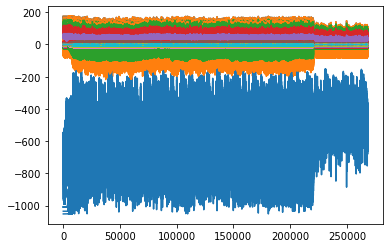

In [10]:
def extract_features(audio,rate):

    mfc_coefficients = np.squeeze(librosa.feature.mfcc(y=audio, sr=rate, n_mfcc=20, hop_length=8000))
    deltas = librosa.feature.delta(mfc_coefficients, mode='nearest')

    
    combined = np.hstack((mfc_coefficients, deltas))

    #print(np.min(combined), np.max(combined), np.mean(combined), np.std(combined))
    #print(mfc_coefficients.shape, deltas.shape, combined.shape)
    plt.plot(combined)

    return combined

db = database.connect_to_database()
features_list = []

"""

for filename in ["myrecording5.wav", "myrecording6.wav"]:
    with soundfile.SoundFile(filename) as audio:
        waveform = audio.read(dtype="float32")
        sample_rate = audio.samplerate
        features = extract_features(waveform, sample_rate)
        features_list.append(features)

gmm_model = generate_gmm(features_list, len(features_list))
"""


for i, filename in enumerate(os.listdir(os.getcwd())):
    if not filename.endswith(".wav"):
        continue
    with soundfile.SoundFile(filename) as audio:
        waveform = audio.read(dtype="float32")
        sample_rate = audio.samplerate
        user = "user " + str(i)
        password = "password " + str(i)
        email = "sexydiegus6969" + str(i) + "@gmail.com"
        features = extract_features(waveform, sample_rate)
        features_list.append(features)


        #store the features in a file
        np.savetxt("features/" + user + ".csv", features)

        model = None


        database.addUser(db.users, database.createUser(user, email, password.encode('utf-8'), "features/" + user + ".csv", model))


In [11]:
for f in features_list:
    print(f.shape)

(220500, 40)
(220500, 40)
(220500, 40)
(220500, 40)
(220500, 40)
(268237, 40)
(220500, 40)


In [7]:
#features_list.pop(5)
#reshape every element of features_list to one dimension
#features_list = np.array(features_list).reshape(-1,1)

#features_list = np.array(features_list).flatten()
labels = generate_gmm(features_list, len(features_list))


ValueError: Found array with dim 3. Estimator expected <= 2.

In [ ]:
for f in features_list:
    print(f.shape)
#remove the fifth element of features_list


(220500, 40)
(220500, 40)
(220500, 40)
(220500, 40)
(220500, 40)
(268237, 40)
(220500, 40)


In [ ]:
labels0 = features_list[labels == 0]
labels1 = features_list[labels == 1]

plt.plot(labels0[0])
plt.plot(labels0[1])
plt.show()

plt.plot(labels0[0])
plt.plot(labels1[0])
plt.show()

NameError: name 'labels' is not defined

In [ ]:
db.list_database_names()
for user in db.users.users.find():
    db.users.users.delete_one(user)